(Исходными данными являются:
– количество муравейников (M);
– количество муравьёв, приходящихся на один муравейник (n);
– координаты муравейников Xi, Yi.

Параметрами настройки алгоритма являются:
– степень влияния феромона (α);
– степень влияния расстояния (β);
– коэффициент, учитывающий испарение феромона (φ).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np
from gensim.models import Word2Vec
import dgl
import dgl.nn as gnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy
import copy
import random as rd

Using backend: pytorch


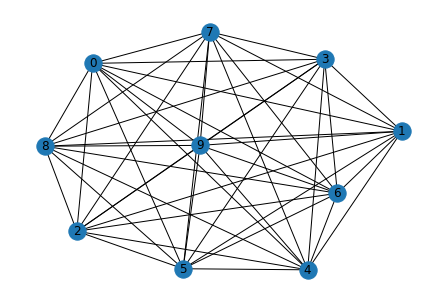

In [2]:
num_nodes = 10
def generate_graph(n, p):
    g1 = nx.gnp_random_graph(n, p)
    nx.draw(g1, pos = nx.spring_layout(g1), with_labels = True)
    # create dgl graph from networkx
    g = dgl.from_networkx(g1)
    valume1 = g.edges()[0 ].tolist()
    valume2 = g.edges()[1].tolist()
    data = np.array([valume1, valume2]).T
    data_edges = pd.DataFrame(data=data)
    weights = np.random.randint(6, 40, len(data_edges)).tolist()
    pheromones = np.random.randint(1, 5, len(data_edges)).tolist()
    # this is necessary for the same edges to be equal
    for i in range(len(data_edges)):
        x = np.random.randint(0, 40, 1)[0]
        edge = (data_edges[0][i], data_edges[1][i])
        for j in range(len(data_edges[1])):
            if edge == (data_edges[1][j], data_edges[0][j]):
                weights[j] = weights[i] 
    data_edges['weights'] = weights
    data_edges['pheromones'] = pheromones
    # append weights to edges
    g.edata['weights'] = torch.tensor(weights,  dtype=torch.int32)
    g.edata['pheromones'] = torch.tensor(pheromones,  dtype=torch.int32)
    return g
g = generate_graph(num_nodes, 1)

In [3]:
g.edata

{'weights': tensor([26,  9, 11, 13, 22, 19, 18, 19, 26, 26, 12, 39,  6, 21, 25, 20,  6, 36,
         9, 12, 34, 36, 24, 33, 10, 20, 21, 11, 39, 34,  7,  9, 12, 12, 12,  7,
        13,  6, 36,  7, 10, 33, 16, 29, 16, 22, 21, 24,  9, 10, 19, 11, 13, 20,
        19, 25, 33, 12, 33, 19, 11,  8, 10, 18, 20, 10, 12, 16, 11, 11, 38, 12,
        19,  6, 20, 12, 29, 13,  8, 38, 32, 26, 36, 21,  7, 16, 20, 10, 12, 32],
       dtype=torch.int32), 'pheromones': tensor([1, 2, 3, 4, 4, 1, 2, 2, 2, 2, 3, 3, 1, 1, 3, 2, 1, 4, 4, 2, 2, 1, 4, 4,
        1, 4, 1, 3, 4, 1, 3, 3, 2, 3, 4, 2, 2, 1, 1, 1, 4, 1, 4, 4, 4, 3, 2, 2,
        1, 2, 1, 2, 4, 4, 2, 2, 2, 4, 1, 1, 1, 3, 2, 4, 1, 1, 1, 1, 2, 2, 4, 3,
        1, 2, 1, 3, 1, 1, 1, 4, 4, 4, 4, 3, 3, 2, 2, 2, 2, 3],
       dtype=torch.int32)}

In [4]:
g.edges()

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]))

In [58]:
# бесполезная вероятность
def probability_transaction(g, node, alpha, beta):
    nominator = [(1/g.edata['weights'][i].tolist())**beta*g.edata['pheromones'][i].tolist()**alpha for i in range(len(g.edges()[0].tolist())) if g.edges()[0].tolist()[i] == node]
    denominator = sum([(g.edata['pheromones'][i].tolist()**alpha)/g.edata['weights'][i].tolist()**beta for i in range(len(g.edges()[0].tolist())) if g.edges()[0].tolist()[i] == node])
    list_P = [100*nominator[i]/denominator for i in range(len(nominator))]
    return list_P


# вероятность посещения непройденных вершин, заданных списком
def probability_transaction2(g, node, S0, alpha, beta):
    nominator = [(1/g.edata['weights'][i].tolist())**beta*g.edata['pheromones'][i].tolist()**alpha for i in range(len(g.edges()[0].tolist())) if (g.edges()[0].tolist()[i] == node and g.edges()[1].tolist()[i] in S0)]
    denominator = sum([(g.edata['pheromones'][i].tolist()**alpha)/g.edata['weights'][i].tolist()**beta for i in range(len(g.edges()[0].tolist())) if (g.edges()[0].tolist()[i] == node and g.edges()[1].tolist()[i] in S0)])
    list_P = [nominator[i]/denominator for i in range(len(nominator))]
    return list_P

# вероятность для одной вершины
def probability_transaction_one(g, node1, node2, alpha, beta):
    for i in range(len(g.edges()[0].tolist())):
        if (g.edges()[0].tolist()[i] == node1 and g.edges()[1].tolist()[i] == node2):
            ph = g.edata['pheromones'][i].tolist()
            weig = g.edata['weights'][i].tolist()
    nominator = (1/weig**beta)*(ph**alpha)
    denominator = sum([(g.edata['pheromones'][k].tolist()**alpha)/(g.edata['weights'][k].tolist()**beta) for k in range(len(g.edges()[0].tolist())) if g.edges()[0].tolist()[k] == node1])
    P = 100*nominator/denominator  
    return P

# count distance of path from one node to other node
def count_distance_edge(g, node1, node2):
    distance = [g.edata['weights'].tolist()[i] for i in range(len(g.edges()[0].tolist())) if (g.edges()[0][i] == node1 and g.edges()[1][i] == node2)]
    return distance[0]
    
# count distance of path
def count_distance(g, S0):
    L = 0
    for i in range(len(S0)-1):
        L+= g.edata['weights'][S0[i+1]]
    return L    
    
# count average distance between anthills    
def average_distance(g, M):
    L = 0
    for i in g.edata['weights'].tolist():
        L += i
    average_dist = 2*L/M*(M-1)
    return average_dist

def distance(g):        
    length =[]
    dis = 0
    for i in range(len(g.ndata['ant_path'])):
        for j in range(len(g.ndata['ant_path'][i]) - 1):
            dis += distmat[g.ndata['ant_path'][i][j]][g.ndata['ant_path'][i][j + 1]]
        dis += distmat[g.ndata['ant_path'][i][-1]][g.ndata['ant_path'][i][0]]
        length.append(dis)
        dis = 0
    return length

probability_transaction(g, 1, 4, 3)

[0.8760924115254821, 0.03737994289175392, 0.08652764558276367]


[6.319349126575861,
 62.48379873689508,
 1.8201925895135576,
 6.171239381421738,
 0.1439356123946761,
 6.910208269910704,
 2.6659754127741917,
 6.171239381421738,
 7.31406148909243]

In [59]:
# просто достраиваю атрибуты графа
num_hills = num_nodes
ant_path = np.zeros((num_hills, num_nodes)).astype(int) - 1
pheromones = np.ones((num_hills, num_nodes)).astype(int) 
pheromone_weights = np.zeros((len(g.edata['pheromones']), 1)).astype(int)
# будем запоминать путь каждого муравья
g.ndata['ant_path'] = torch.tensor(ant_path,  dtype=torch.int32)
g.edata['pheromone_weights'] =  torch.tensor(pheromone_weights,  dtype=torch.float32)
g.ndata['pheromones'] = torch.tensor(pheromones,  dtype=torch.float32)
# матрица для весов дорог
weights_nodes = np.zeros((num_hills, num_nodes)).astype(int)
# заполняем рандомными весами
for i in range(len(weights_nodes[0])):
    for j in range(len(weights_nodes)):
        if i == j:
            weights_nodes[i, j] = 0
        else:
            x = np.random.randint(1, 100, 1)
            weights_nodes[i, j], weights_nodes[j, i] = x, x
        
g.ndata['weighted_nodes'] = torch.tensor(weights_nodes, dtype = torch.int32)

In [68]:
# Гиперпараметры         
alpha = 1                 
beta = 3                     
learn_rate = 0.3           
num_nodes = 10
epochs = 100                   

for epoch in range(epochs):
    g.ndata['ant_path'] = torch.tensor(ant_path,  dtype=torch.int32)   
    firstCity = [i for i in range(num_nodes)]
    rd.shuffle(firstCity)         
    tabu = []
    p = []
    P = 0
    for i in range(len(g.ndata['ant_path'].tolist())):
        g.ndata['ant_path'][i][0] = firstCity[i]
    for i in range(len(g.ndata['ant_path'][0].tolist()) - 1):       
        for j in range(len(g.ndata['ant_path'].tolist())):
            for k in range(num_nodes):
                if k not in g.ndata['ant_path'][j].tolist():
                    tabu.append(k)
            for node1 in tabu:
                P += g.ndata['pheromones'][g.ndata['ant_path'][j][i].tolist()][node1] ** alpha * (1/g.ndata['weighted_nodes'][g.ndata['ant_path'][j][i].tolist()][node1]) ** beta
            for node2 in tabu:
                p.append(g.ndata['pheromones'][g.ndata['ant_path'][j][i].tolist()][node2] ** alpha * (1/g.ndata['weighted_nodes'][g.ndata['ant_path'][j][i].tolist()][node2]) ** beta / P)
            rand = np.array(p).cumsum()             
            r = rd.uniform(min(rand), max(rand))
            for x in range(len(rand)):
                if rand[x] >= r:                  
                    g.ndata['ant_path'][j][i + 1] = tabu[x]
                    break
            tabu = []
            p = []
            P = 0
    g.ndata['pheromones'] = (1 - learn_rate)*g.ndata['pheromones']          
    length = distance(g)
    for i in range(len(g.ndata['ant_path'].tolist())):
        for j in range(len(g.ndata['ant_path'].tolist()[i]) - 1):
            g.ndata['pheromones'][g.ndata['ant_path'][i][j].tolist()][g.ndata['ant_path'][i][j + 1].tolist()] += 1 / length[i]     # Обновление феромона
        g.ndata['pheromones'][g.ndata['ant_path'][i][-1].tolist()][g.ndata['ant_path'][i][0].tolist()] += 1 / length[i]
    iter += 1


print(f' Кратчайший путь: {g.ndata["ant_path"].tolist()[length.index(min(length))]}')    
print(f' Наименьшая дистанция: {min(length)}')

 Кратчайший путь: [3, 1, 2, 9, 7, 8, 6, 4, 5, 0]
 Наименьшая дистанция: 507
